## Imports

In [13]:
import sympy as sp
import numpy as np
from scipy.linalg import eigh
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

## Helpers

In [14]:
# Helpers

def eigenvalues_of_hessian(hessian_matrix, point):
    hessian_numeric = np.array([[entry.evalf(subs=point) for entry in row] for row in hessian_matrix], dtype=float)
    eigenvalues, _ = eigh(hessian_numeric)
    return eigenvalues

def vector_norm(vector):
    squared_sum = sum(component ** 2 for component in vector)
    norm = squared_sum ** 0.5
    return norm

def min_eigenvalue_and_eigenvector(matrix):
    eigenvalues, eigenvectors = eigh(np.array(matrix))
    min_eigenvalue_index = np.argmin(eigenvalues)
    min_eigenvalue = eigenvalues[min_eigenvalue_index]
    corresponding_eigenvector = eigenvectors[:, min_eigenvalue_index]
    return min_eigenvalue, corresponding_eigenvector

def dot_product(vector1, vector2):
    return np.dot(vector1, vector2)

def outer_product(vector1, vector2):
    return np.outer(vector1, vector2)

## Oracles

In [15]:
# Oracles

def firstOrderGradientOracle(func, variables, point, noise_scale, batch_size):
    gradients = []
    for var in variables:
        gradient = sp.diff(func, var)
        gradient_value = gradient.subs(point)
        noisy_gradient_value = gradient_value + np.random.normal(scale=noise_scale)
        gradients.append(noisy_gradient_value)
    return gradients

def firstOrderHessianOracle(func, variables, point, noise_scale, batch_size):
    hessian_matrix = []
    for var1 in variables:
        row = []
        for var2 in variables:
            hessian_entry = sp.diff(sp.diff(func, var1), var2)
            hessian_value = hessian_entry.subs(point) + np.random.normal(scale=noise_scale)
            row.append(hessian_value)
        hessian_matrix.append(row)
    return np.array(hessian_matrix, dtype=float)

def zerothOrderOracle(func, point, noise_scale):
    true_value = func.subs(point)
    noisy_value = true_value + np.random.normal(scale=noise_scale)
    return noisy_value

## SPSA

In [16]:
# SPSA
def spsaGradientEstimate(func, variables, point, delta, noise_scale, batch_size):
    num_vars = len(variables)
    grad_estimate = np.zeros(num_vars)
    for _ in range(batch_size):
        delta_vector = 2 * np.random.randint(0, 2, size=(num_vars,)) - 1  
        perturbed_point_plus = {var: point[var] + delta * delta_vector[i] for i, var in enumerate(variables)}
        perturbed_point_minus = {var: point[var] - delta * delta_vector[i] for i, var in enumerate(variables)}
        
        func_plus = zerothOrderOracle(func, perturbed_point_plus, noise_scale)
        func_minus = zerothOrderOracle(func, perturbed_point_minus, noise_scale)
        
        grad_estimate = grad_estimate + (func_plus - func_minus) / (2 * delta * delta_vector)
    
    return grad_estimate / batch_size

def spsaHessianEstimate(func, variables, point, delta, noise_scale, batch_size):
    num_vars = len(variables)
    hessian_estimate = np.zeros((num_vars, num_vars))
    for _ in range(batch_size):
        delta_vector1 = 2 * np.random.randint(0, 2, size=(num_vars,)) - 1  
        delta_vector2 = 2 * np.random.randint(0, 2, size=(num_vars,)) - 1  
        perturbed_point_plus_plus = {var: point[var] + delta * delta_vector1[i] + delta * delta_vector2[i] for i, var in enumerate(variables)}
        perturbed_point_plus_minus = {var: point[var] + delta * delta_vector1[i] - delta * delta_vector2[i] for i, var in enumerate(variables)}
        perturbed_point_minus_plus = {var: point[var] - delta * delta_vector1[i] + delta * delta_vector2[i] for i, var in enumerate(variables)}
        perturbed_point_minus_minus = {var: point[var] - delta * delta_vector1[i] - delta * delta_vector2[i] for i, var in enumerate(variables)}

        func_plus_plus = zerothOrderOracle(func, perturbed_point_plus_plus, noise_scale)
        func_plus_minus = zerothOrderOracle(func, perturbed_point_plus_minus, noise_scale)
        func_minus_plus = zerothOrderOracle(func, perturbed_point_minus_plus, noise_scale)
        func_minus_minus = zerothOrderOracle(func, perturbed_point_minus_minus, noise_scale)
        
        hessian_estimate += np.array(func_plus_plus - func_plus_minus - func_minus_plus + func_minus_minus, float) / (4 * delta * delta * outer_product(delta_vector1, delta_vector2))
    
    return np.array(hessian_estimate / batch_size, dtype = float)

## Algorithm

In [17]:
# Algorithm

def gradient_descent_step_1(func, variables, point, gradient_value, L):
    direction = gradient_value
    learning_rate = 1/L
    updated_point = {var: point[var] - learning_rate * component for var, component in zip(variables, direction)}
    return updated_point

def gradient_descent_step_2(func, variables, point, eigenvector, eigenvalue, M):
    learning_rate = 2*abs(eigenvalue)/M
    direction = eigenvector
    updated_point = {var: point[var] - learning_rate * component for var, component in zip(variables, direction)}
    return updated_point

def simulate(func, variables, point, setting, L, M, epsilon_g, epsilon_h, noise, batch_size, delta):

    grad_norm_seq = []
    lambda_min_seq = []
    while True:

        try:
            gradient_value = []
            hessian_value = []
            if setting == 'firstOrder':
                gradient_value = firstOrderGradientOracle(func, variables, point, noise, batch_size)
                hessian_value = firstOrderHessianOracle(func, variables, point, noise, batch_size)
            elif setting == 'zerothOrder':
                gradient_value = spsaGradientEstimate(func, variables, point, delta, noise, batch_size)
                hessian_value = spsaHessianEstimate(func, variables, point, delta, noise, batch_size)

            gradient_norm = vector_norm(gradient_value)
            lambda_min, eigenvector = min_eigenvalue_and_eigenvector(hessian_value)

            grad_norm_seq.append(gradient_norm)
            lambda_min_seq.append(lambda_min)
            
            print(point)
            print(gradient_norm)
            print(lambda_min)
            if gradient_norm > epsilon_g:
                print("Step 1")
                point = gradient_descent_step_1(func, variables, point, gradient_value, L)
            elif lambda_min<-epsilon_h :
                print("Step 2")
                eigenvector = eigenvector/vector_norm(eigenvector)
                if dot_product(eigenvector, gradient_value) > 0:
                    eigenvector = -eigenvector
                point = gradient_descent_step_2(func, variables, point, eigenvector, lambda_min, M)
            else:
                break
        except KeyboardInterrupt:
            break
    
    return grad_norm_seq, lambda_min_seq, point

## Plot

In [18]:
# Plot Results

def plot(list1, list2):

    plt.plot(list1, label = 'Gradient Norm Values')
    plt.xlabel('Iterations')
    plt.ylabel('Values')
    plt.show()

    plt.plot(list2, label = 'Minimum Eigenvalue of Hessian')
    plt.xlabel('Iterations')
    plt.ylabel('Values')
    plt.show()

## Run

{x1: 0.50255}
0.102746270428636
-417.1355568108886
Step 2
{x1: 0.5859771113621778}
31.0200428870099
-354.70466787911545
Step 1
{x1: 0.589079115650879}
32.1654189099845
-349.68982771224586
Step 1
{x1: 0.592295657541877}
33.1155504285538
-364.9429782698283
Step 1
{x1: 0.595607212584733}
34.1153112744582
-317.5115826215484
Step 1
{x1: 0.599018743712178}
35.1869754162528
-328.551305407266
Step 1
{x1: 0.602537441253804}
36.3576031652117
-340.8621758405248
Step 1
{x1: 0.606173201570325}
37.4212676619275
-315.7133143775797
Step 1
{x1: 0.609915328336518}
38.7131094313523
-305.87333112977166
Step 1
{x1: 0.613786639279653}
39.6460293296318
-306.6953323799146
Step 1
{x1: 0.617751242212616}
40.6451647009191
-278.74666781098796
Step 1
{x1: 0.621815758682708}
42.3646577808688
-273.1087200082599
Step 1
{x1: 0.626052224460795}
43.7954941538818
-266.61914006206445
Step 1
{x1: 0.630431773876183}
45.0314340547558
-266.2403160782335
Step 1
{x1: 0.634934917281659}
45.4672486302347
-252.43901247739583
Step 

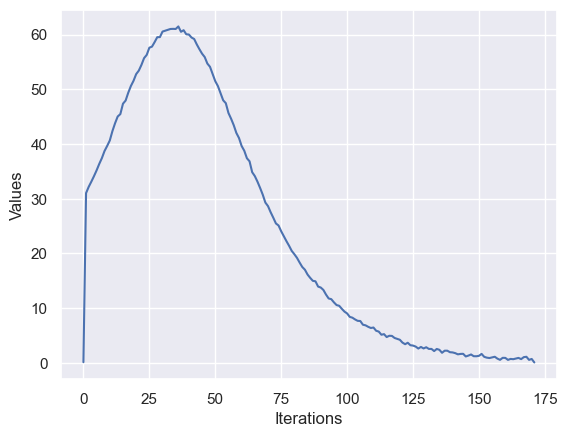

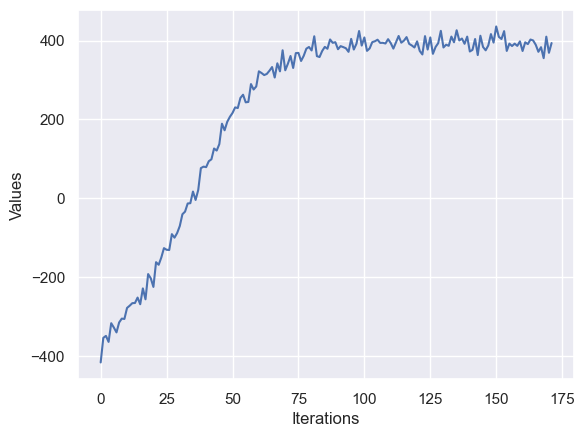

{x1: 0.993634449148567}
172


In [33]:
# variables = sp.symbols('x y')
# print(variables)
# func = x**2 + y**2
# variables = [x, y]
# point = {x:1, y:1}

n = 1
variables = sp.symbols('x1:{0}'.format(n+1))
func = 10 * n + sum(var**2 - 10 * sp.cos(2 * np.pi * var) for var in variables)
point = {var: 0.50255 for var in variables}
# 0.50255

# n = 1
# variables = sp.symbols('x1:{0}'.format(n+1))
# func = 10 * n + sum((var**4 -9*(var**2)) for var in variables)
# point = {var: 0 for var in variables}

# n = 10
# variables = sp.symbols('x1:{0}'.format(n+1))
# func = sum(var**2 for var in variables)
# point = {var: 10 for var in variables}


L = 10000 # Smoothness Constant
M = 10000 # Taylor Constant
batch_size = 1000
epsilon_g = 0.4
epsilon_h = 0.4
noise = 0.1
delta = 0.01 # SPSA constant for zeroth order
setting = 'zerothOrder' # firstOrder, zerothOrder

grad_norm_seq, lambda_min_seq, point = simulate(func, variables, point, setting, L, M, epsilon_g, epsilon_h, noise, batch_size, delta)
plot(grad_norm_seq, lambda_min_seq)
print(point)
print(len(grad_norm_seq))